### Provide your credentials to the runtime

In [1]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


## Optional: Enable data table display

Colab includes the ``google.colab.data_table`` package that can be used to display large pandas dataframes as an interactive data table.
It can be enabled with:

In [0]:
%load_ext google.colab.data_table

If you would prefer to return to the classic Pandas dataframe display, you can disable this by running:
```python
%unload_ext google.colab.data_table
```

Question 1


In [5]:
# Display query output immediately

%%bigquery --project assignment-11-259400
SELECT 
  COUNT(*) as total_rows
FROM `bigquery-public-data.samples.gsod`

,total_rows
0,114420316


In [0]:
# Save output in a variable `df`

%%bigquery --project assignment-11-259400 df
SELECT 
  COUNT(*) as total_rows
FROM `bigquery-public-data.samples.gsod`

In [7]:
df

,total_rows
0,114420316


In [9]:
#standardSQL
%%bigquery --project assignment-11-259400

CREATE OR REPLACE MODEL `mydata.sample_model` 
OPTIONS(model_type='logistic_reg') AS
SELECT
  IF(totals.transactions IS NULL, 0, 1) AS label,
  IFNULL(device.operatingSystem, "") AS os,
  device.isMobile AS is_mobile,
  IFNULL(geoNetwork.country, "") AS country,
  IFNULL(totals.pageviews, 0) AS pageviews
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
  _TABLE_SUFFIX BETWEEN '20160801' AND '20170631'
LIMIT 100000;

""


In [10]:
%%bigquery --project assignment-11-259400

#standardSQL
SELECT
  *
FROM
  ml.EVALUATE(MODEL `mydata.sample_model`, (
SELECT
  IF(totals.transactions IS NULL, 0, 1) AS label,
  IFNULL(device.operatingSystem, "") AS os,
  device.isMobile AS is_mobile,
  IFNULL(geoNetwork.country, "") AS country,
  IFNULL(totals.pageviews, 0) AS pageviews
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
  _TABLE_SUFFIX BETWEEN '20170701' AND '20170801'));

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.428571,0.086592,0.985141,0.144074,0.047767,0.983433


In [11]:
%%bigquery --project assignment-11-259400

#standardSQL
SELECT
  country,
  SUM(predicted_label) as total_predicted_purchases
FROM
  ml.PREDICT(MODEL `mydata.sample_model`, (
SELECT
  IFNULL(device.operatingSystem, "") AS os,
  device.isMobile AS is_mobile,
  IFNULL(totals.pageviews, 0) AS pageviews,
  IFNULL(geoNetwork.country, "") AS country
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
  _TABLE_SUFFIX BETWEEN '20170701' AND '20170801'))
GROUP BY country
ORDER BY total_predicted_purchases DESC
LIMIT 10;

,country,total_predicted_purchases
0,United States,181
1,Canada,8
2,Taiwan,8
3,India,2
4,Turkey,2
5,Japan,2
6,United Kingdom,1
7,Thailand,1
8,St. Lucia,1
9,Guyana,1


In [12]:
%%bigquery --project assignment-11-259400

#standardSQL
SELECT
  fullVisitorId,
  SUM(predicted_label) as total_predicted_purchases
FROM
  ml.PREDICT(MODEL `mydata.sample_model`, (
SELECT
  IFNULL(device.operatingSystem, "") AS os,
  device.isMobile AS is_mobile,
  IFNULL(totals.pageviews, 0) AS pageviews,
  IFNULL(geoNetwork.country, "") AS country,
  fullVisitorId
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_*`
WHERE
  _TABLE_SUFFIX BETWEEN '20170701' AND '20170801'))
GROUP BY fullVisitorId
ORDER BY total_predicted_purchases DESC
LIMIT 10;

,fullVisitorId,total_predicted_purchases
0,9417857471295131045,4
1,0376394056092189113,2
2,8388931032955052746,2
3,2969418676126258798,2
4,806992249032686650,2
5,489038402765684003,2
6,057693500927581077,2
7,7420300501523012460,2
8,112288330928895942,2
9,1280993661204347450,2


Question 2

In [13]:
%%bigquery --project assignment-11-259400

SELECT
  *
FROM
  `bigquery-public-data.ml_datasets.census_adult_income`
LIMIT
  100;

,age,workclass,functional_weight,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,Private,297847,9th,5,Married-civ-spouse,Other-service,Wife,Black,Female,3411,0,34,United-States,<=50K
1,72,Private,74141,9th,5,Married-civ-spouse,Exec-managerial,Wife,Asian-Pac-Islander,Female,0,0,48,United-States,>50K
2,45,Private,178215,9th,5,Married-civ-spouse,Machine-op-inspct,Wife,White,Female,0,0,40,United-States,>50K
3,31,Private,86958,9th,5,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
4,55,Private,176012,9th,5,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,23,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,30,Local-gov,48542,12th,8,Married-civ-spouse,Adm-clerical,Wife,White,Female,0,0,40,United-States,<=50K
96,53,?,155233,12th,8,Married-civ-spouse,?,Wife,White,Female,0,0,40,Italy,<=50K
97,52,?,89951,12th,8,Married-civ-spouse,?,Wife,Black,Female,0,0,40,United-States,>50K
98,45,Private,81400,1st-4th,2,Married-civ-spouse,Other-service,Wife,White,Female,0,0,25,El-Salvador,<=50K


In [14]:
%%bigquery --project assignment-11-259400

CREATE OR REPLACE VIEW
  `census.input_view` AS
SELECT
  age,
  workclass,
  native_country,
  marital_status,
  education_num,
  occupation,
  race,
  hours_per_week,
  income_bracket,
  CASE
    WHEN MOD(functional_weight, 10) < 8 THEN 'training'
    WHEN MOD(functional_weight, 10) = 8 THEN 'evaluation'
    WHEN MOD(functional_weight, 10) = 9 THEN 'prediction'
  END AS dataframe
FROM
  `bigquery-public-data.ml_datasets.census_adult_income`

""


In [15]:
%%bigquery --project assignment-11-259400

CREATE OR REPLACE MODEL
  `census.census_model`
OPTIONS
  ( model_type='LOGISTIC_REG',
    auto_class_weights=TRUE,
    input_label_cols=['income_bracket']
  ) AS
SELECT
  *
FROM
  `census.input_view`
WHERE
  dataframe = 'training'

""


In [16]:
%%bigquery --project assignment-11-259400

SELECT
  *
FROM
  ML.EVALUATE (MODEL `census.census_model`,
    (
    SELECT
      *
    FROM
      `census.input_view`
    WHERE
      dataframe = 'evaluation'
    )
  )

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.555556,0.794837,0.808122,0.653997,0.411307,0.882668


In [17]:
%%bigquery --project assignment-11-259400

SELECT
  *
FROM
  ML.PREDICT (MODEL `census.census_model`,
    (
    SELECT
      *
    FROM
      `census.input_view`
    WHERE
      dataframe = 'prediction'
     )
  )

,predicted_income_bracket,predicted_income_bracket_probs,age,workclass,native_country,marital_status,education_num,occupation,race,hours_per_week,income_bracket,dataframe
0,<=50K,"[{'label': ' >50K', 'prob': 0.2012969407976484...",52,Local-gov,United-States,Married-civ-spouse,5,Other-service,White,40,<=50K,prediction
1,<=50K,"[{'label': ' >50K', 'prob': 0.1008541201455689...",34,?,United-States,Married-civ-spouse,7,?,White,8,<=50K,prediction
2,<=50K,"[{'label': ' >50K', 'prob': 0.2991506986395517...",47,Private,United-States,Married-civ-spouse,7,Machine-op-inspct,Black,40,<=50K,prediction
3,<=50K,"[{'label': ' >50K', 'prob': 0.1678983874411769...",43,Private,United-States,Married-civ-spouse,7,Handlers-cleaners,White,25,<=50K,prediction
4,<=50K,"[{'label': ' >50K', 'prob': 0.3286106704611063...",54,Private,United-States,Married-civ-spouse,7,Other-service,White,43,<=50K,prediction
...,...,...,...,...,...,...,...,...,...,...,...,...
3137,<=50K,"[{'label': ' >50K', 'prob': 0.0363531416737578...",23,Private,United-States,Never-married,10,Other-service,White,40,<=50K,prediction
3138,<=50K,"[{'label': ' >50K', 'prob': 0.0486241458069540...",35,Private,United-States,Never-married,10,Machine-op-inspct,Amer-Indian-Eskimo,40,<=50K,prediction
3139,<=50K,"[{'label': ' >50K', 'prob': 0.0297920238027513...",19,?,United-States,Never-married,10,?,White,30,<=50K,prediction
3140,<=50K,"[{'label': ' >50K', 'prob': 0.0257815423224425...",26,Private,?,Never-married,10,Handlers-cleaners,Black,40,<=50K,prediction


Question 3

In [18]:
%%bigquery --project assignment-11-259400

WITH
  hs AS (
  SELECT
    h.start_station_name AS station_name,
    h.duration,
    ST_DISTANCE(ST_GEOGPOINT(s.longitude,
        s.latitude),
      ST_GEOGPOINT(-0.1,
        51.5))/1000 AS distance_from_city_center
  FROM
    `bigquery-public-data.london_bicycles.cycle_hire` AS h
  JOIN
    `bigquery-public-data.london_bicycles.cycle_stations` AS s
  ON
    h.start_station_id = s.id
  WHERE
    h.start_date BETWEEN CAST('2015-01-01 00:00:00' AS TIMESTAMP)
    AND CAST('2016-01-01 00:00:00' AS TIMESTAMP) ),
  stationstats AS (
  SELECT
    station_name,
    AVG(duration) AS duration,
    COUNT(duration) AS num_trips,
    MAX(distance_from_city_center) AS distance_from_city_center
  FROM
    hs
  GROUP BY
    station_name )
SELECT
  *
FROM
  stationstats
ORDER BY
  distance_from_city_center ASC

,station_name,duration,num_trips,distance_from_city_center
0,"Borough Road, Elephant & Castle",1349.318091,7523,0.126240
1,"Webber Street , Southwark",823.879056,8136,0.164021
2,"Great Suffolk Street, The Borough",844.355487,10442,0.193667
3,"LSBU (Borough Road), Elephant & Castle",1297.835314,7068,0.257903
4,"Harper Road, Borough",822.686747,1660,0.306306
...,...,...,...,...
787,"Bridge Avenue, Hammersmith",2269.098519,9318,8.981545
788,"Montserrat Road , Putney",2648.183079,4326,8.986740
789,"Disraeli Road, Putney",1777.219098,8357,9.105643
790,"Putney Rail Station, Putney",3715.898645,3394,9.175861


In [19]:
%%bigquery --project assignment-11-259400

CREATE OR REPLACE MODEL
  bqml_tutorial.london_station_clusters OPTIONS(model_type='kmeans',
    num_clusters=4) AS
WITH
  hs AS (
  SELECT
    h.start_station_name AS station_name,
  IF
    (EXTRACT(DAYOFWEEK
      FROM
        h.start_date) = 1
      OR EXTRACT(DAYOFWEEK
      FROM
        h.start_date) = 7,
      "weekend",
      "weekday") AS isweekday,
    h.duration,
    ST_DISTANCE(ST_GEOGPOINT(s.longitude,
        s.latitude),
      ST_GEOGPOINT(-0.1,
        51.5))/1000 AS distance_from_city_center
  FROM
    `bigquery-public-data.london_bicycles.cycle_hire` AS h
  JOIN
    `bigquery-public-data.london_bicycles.cycle_stations` AS s
  ON
    h.start_station_id = s.id
  WHERE
    h.start_date BETWEEN CAST('2015-01-01 00:00:00' AS TIMESTAMP)
    AND CAST('2016-01-01 00:00:00' AS TIMESTAMP) ),
  stationstats AS (
  SELECT
    station_name,
    isweekday,
    AVG(duration) AS duration,
    COUNT(duration) AS num_trips,
    MAX(distance_from_city_center) AS distance_from_city_center
  FROM
    hs
  GROUP BY
    station_name, isweekday)
SELECT
  * EXCEPT(station_name, isweekday)
FROM
  stationstats

""


In [20]:
%%bigquery --project assignment-11-259400

WITH
  hs AS (
  SELECT
    h.start_station_name AS station_name,
    h.duration,
    ST_DISTANCE(ST_GEOGPOINT(s.longitude,
        s.latitude),
      ST_GEOGPOINT(-0.1,
        51.5))/1000 AS distance_from_city_center
  FROM
    `bigquery-public-data.london_bicycles.cycle_hire` AS h
  JOIN
    `bigquery-public-data.london_bicycles.cycle_stations` AS s
  ON
    h.start_station_id = s.id
  WHERE
    h.start_date BETWEEN CAST('2015-01-01 00:00:00' AS TIMESTAMP)
    AND CAST('2016-01-01 00:00:00' AS TIMESTAMP) ),
  stationstats AS (
  SELECT
    station_name,
    AVG(duration) AS duration,
    COUNT(duration) AS num_trips,
    MAX(distance_from_city_center) AS distance_from_city_center
  FROM
    hs
  GROUP BY
    station_name )
SELECT
  * EXCEPT(nearest_centroids_distance)
FROM
  ML.PREDICT( MODEL bqml_tutorial.london_station_clusters,
    (
    SELECT
      *
    FROM
      stationstats
    WHERE
      REGEXP_CONTAINS(station_name, 'Kennington')))

,CENTROID_ID,station_name,duration,num_trips,distance_from_city_center
0,1,"Kennington Road Post Office, Oval",2096.259542,7074,1.846033
1,1,"Cleaver Street, Kennington",1231.158015,5259,1.496792
2,1,"Doddington Grove, Kennington",1532.156098,9225,1.468141
3,2,"Kennington Lane Rail Bridge, Vauxhall",1144.593108,25277,2.175033
4,3,"Kennington Oval, Oval",1325.593913,12485,2.083134
5,2,"Kennington Cross, Kennington",964.901218,19538,1.462588
6,1,"Kennington Road , Vauxhall",1346.311431,11110,0.891565
7,1,"Kennington Station, Kennington",2209.022758,6723,1.298668
8,1,"Cotton Garden Estate, Kennington",1439.843773,6913,1.117034


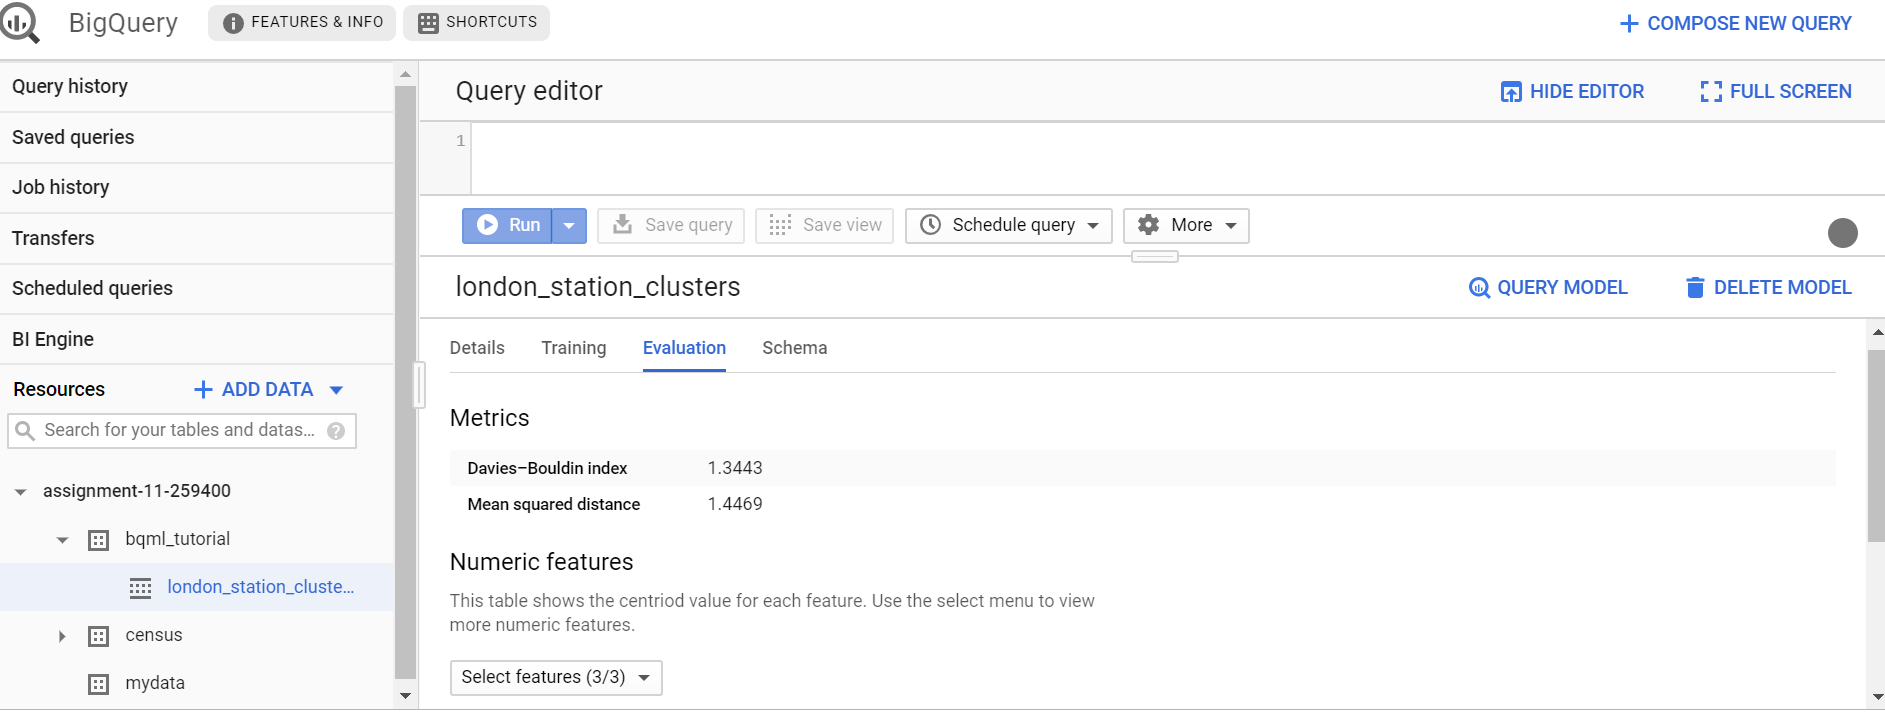

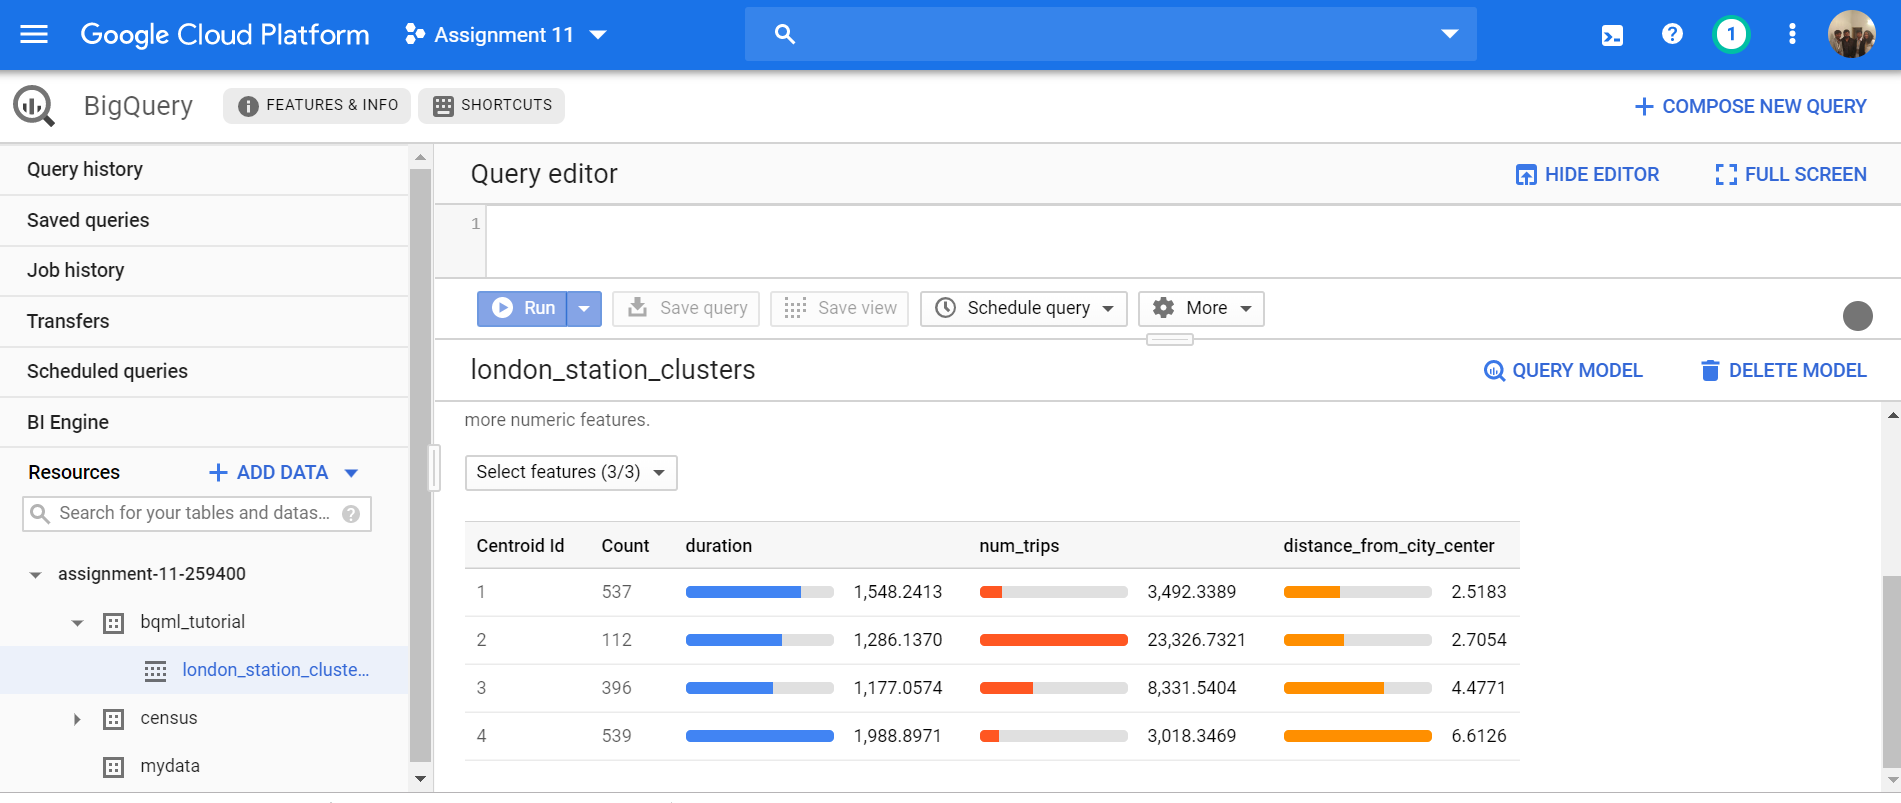

Question 5

In [22]:
%%bigquery --project assignment-11-259400
#standardSQL
CREATE MODEL `bqml_tutorial.natality_model`
OPTIONS
  (model_type='linear_reg',
    input_label_cols=['weight_pounds']) AS
SELECT
  weight_pounds,
  is_male,
  gestation_weeks,
  mother_age,
  CAST(mother_race AS string) AS mother_race
FROM
  `bigquery-public-data.samples.natality`
WHERE
  weight_pounds IS NOT NULL
  AND RAND() < 0.001

""


In [24]:
%%bigquery --project assignment-11-259400
#standardSQL
SELECT
  *
FROM
  ML.EVALUATE(MODEL `bqml_tutorial.natality_model`,
    (
    SELECT
      weight_pounds,
      is_male,
      gestation_weeks,
      mother_age,
      CAST(mother_race AS STRING) AS mother_race
    FROM
      `bigquery-public-data.samples.natality`
    WHERE
      weight_pounds IS NOT NULL))

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,0.955677,1.675756,0.034302,0.737187,0.046438,0.046486


In [25]:
%%bigquery --project assignment-11-259400
#standardSQL
SELECT
  predicted_weight_pounds
FROM
  ML.PREDICT(MODEL `bqml_tutorial.natality_model`,
    (
    SELECT
      is_male,
      gestation_weeks,
      mother_age,
      CAST(mother_race AS STRING) AS mother_race
    FROM
      `bigquery-public-data.samples.natality`
    WHERE
      state = "WY"))

,predicted_weight_pounds
0,7.704173
1,7.623005
2,7.808552
3,7.779212
4,7.454633
...,...
218730,7.573580
218731,7.573580
218732,7.573580
218733,7.573580
